<a href="https://githubtocolab.com/minyeamer/groove_midi/blob/main/README.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# POZAlabs Task
- MusicVAE 구현
- Groove MIDI Dataset을 이용하여 4마디에 해당하는 드럼 샘플 추출 과정 수행
- 깃헙 코드: https://github.com/magenta/magenta/tree/master/magenta/models/music_vae
- 관련 논문: https://arxiv.org/pdf/1803.05428.pdf
- 관련 데이터: https://magenta.tensorflow.org/datasets/groove

## Commentary
- 미디라는 데이터는 음악이 어떻게 연주되어야 하는지 나타내는 악보와 비슷한 개념으로 이해하시면 됩니다.   
  어느 시점에 어떤 악기를 연주하여야 하는지가 나와있는 데이터이며 .midi의 확장자명을 가지고 있습니다.
- 설명드린 코드에서는 해당 미디를 학습에 이용하기 위하여 벡터로 변환하는 전처리 과정이 필요합니다.   
  이러한 전처리 과정을 거치면 tfrecord형식으로 저장되게 되며 이것을 학습하는 형태입니다.
- 추가적으로, 해당 과정(전처리 -> 학습 -> 생성)의 프로세스에 대하여 자유로운 형식으로 정리하여 공유주시면 감사하겠습니다. (학술적인 내용이 포함되면 좋습니다!)
- 과제에 필요한 라이브러리의 dependency 이슈가 있습니다.   
  필요한 라이브러리 설치가 안되는 경우 https://github.com/magenta/magenta/issues/2005 를 참고하시어 진행하시길 바랍니다.
- 과제는 어떠한 방식으로 모델을 다루는지를 보기 위함이며, 과제를 100% 완수하지 못하셔도 됩니다.
- 과제와 관련한 모든 문의는 해당 메일로 회신 부탁드립니다.

## Process
1. Set Environment (1 hour)
2. Explore Background (7 hours)
3. Code Reivew (8 hours)
4. Data Analysis (1 hour)
5. Implementation (5 hours)
6. Complement the Above (4 hours)

<hr>

## Set Environment
- Start with MacOS Monterey 12.4
- Make conda env (using template)
- Try to install Magenta library (08-19 15:00-16:00, 1 hour)
- Continue with Colab instead of MacOS

<hr style="border-style:dotted">

### Magenta Issues

> **Could not find a version that satisfies the requirement tensorflow==2.9.1**
- `tensorflow-macos==2.9.1` 설치 후에도 동일 에러 발생가 발생함을 확인하였습니다.
- 에러 처리를 위해 과거 Issue 내역과 검색 결과 참고하였습니다.
- https://github.com/magenta/magenta/issues/1867
- https://github.com/magenta/magenta/issues/1886
- https://stackoverflow.com/questions/62948255/magenta-installation-using-pip-install-magenta-having-errors-even-on-fresh-env
- 시간 내 과제 해결을 위해선 해당 에러 처리를 고집하는 것보다 우선 되는 환경에서 수행하는 것이 바람직하다 판단하여 Colab 환경에서 진행하기로 했습니다.

In [ ]:
from IPython.display import clear_output
!pip install magenta==2.1.4 # latest
clear_output()

<hr>

## Explore Background
- Find prior knowledge for VAE (08-19 16:00-18:00, 2 hours)
- Review suggested [reference](https://arxiv.org/pdf/1803.05428.pdf) (08-19 18:00-21:00, 3 hours)
- Search additional information for MusicVAE (08-19 22:00-00:00, 2 hours)

<hr style="border-style:dotted">

### VAE(Auto-Encoding Variational Bayes)

<img src="https://user-images.githubusercontent.com/24144491/50323466-18d03700-051d-11e9-82ed-afb1b6e2666a.png" width="50%">

- VAE는, Encoder로 차원축소를 하기 위한 목적의 Audoencoder와 반대로, Decoder로 새로운 데이터를 생성하기 위한 목적을 가집니다.
- 입력 데이터 $x$로부터 인코더를 통해 추출한 특징에 대한 latent vector $z$를, 다시 디코더를 거쳐 $x$와 유사한 데이터로 생성해내는 과정을 거칩니다.
- 우선, $x_i$에 대해 Gaussian Encoder를 통과한 출력 결과인 $\mu, \sigma$를 가지고 정규 분포를 생성하며, 해당 분포에서 $z_i$를 샘플링합니다.
- 다음으로, $z_i$를 가지고 Bernoulli Decoder를 통과하면 $x_i$와 동일한 출력 결과 $p_i$을 생성합니다.
- 샘플링에 대한 역전파 과정을 수행하기 위해 Reparameterization Trick을 사용합니다.   
  ($N(0,1)$을 따르는 정규 분포 $\epsilon_i$에 $\sigma_i^2$를 곱하고 $\mu_i$를 더하는 과정을 통해 backward를 저장하게 됩니다.)
- latent vector로부터 가장 그럴듯한 확률 분포를 찾아내기 때문에, Decoder가 생성한 데이터가 학습 데이터와 닮은 특징을 가집니다.

<br>

#### Backpropagation을 위한 Sampling 과정

```python
import keras.backend as K

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0],latent_dim),mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])
```

<br>

#### Loss Function

<img src="https://user-images.githubusercontent.com/24144491/50323472-1a016400-051d-11e9-86b7-d8bf6a1a880f.png" width="50%">

- Loss Function은 Reconstruction Error(복원 오차)와 Regularization 과정에서 도출되는 KL divergence(제약 조건)의 합으로 구해집니다.
- Reconstruction Error는 확률을 정규 분포로 가정하면 MSE, 이항 분포로 가정하면 CrossEntropy로 정의됩니다. (일반적으론 베르누이로 지정합니다.)
- Regularization은 인코더를 통과해 나온 확률 분포가 정규 분포로 가정된 $p(z)$를 따르도록 하기 위해 두 분포 간 거리(KL divergence)를 최소화하는 과정입니다.
- 증명 과정을 통해 도출된 likelihood에 대한 ELBO 식 $\log{p_{\theta}(x^{(i)})\ge{L(x^{(i)},\theta,\phi)}}$에서 lower bound인 Loss Function을 maximize하는,   
  디코더의 파라미터 $\theta$와 인코더의 파라미터 $\phi$를 찾기 위함이 주 목적입니다.
- 최적화 과정에서는 Loss Function을 최소화하기 위해 Reconstruction Error에 마이너스를 곱해서 계산합니다.

<br>

#### Loss Function 도출 과정

```python
import keras.backend as K

def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(x,z_decoded)
    kl_loss   = -5e-4*K.mean(1+z_log_var-K.square(z_mean)-K.exp(z_log_var),axis=-1)
    return K.mean(xent_loss + kl_loss)
```

<br>

#### References
- [KAIST 스마트설계연구실 강남우 교수(전 숙명여대)의 딥러닝과 설계 강의](https://youtu.be/GbCAwVVKaHY)
- [VAE(Auto-Encoding Variational Bayes) 직관적 이해](https://taeu.github.io/paper/deeplearning-paper-vae/)

<hr style="border-style:dotted">

### A Hierarchical Latent Vector Model for Learning Long-Term Structure in Music

#### 1. Introduction
- 생성 모델링은 데이터 x를 생성하기 위한 확률 분포 $p(x)$를 도출하는 과정입니다.
- 최근(2018)의 생성 모델링 연구는 복잡한 구조를 사용하는 DNN을 통해 가속화되었으며,   
  해당 연구에서는 VAE 등 deep latent variable 모델에 주목합니다.
- 여전히 긴 시퀀스에 대해 deep latent variable 모델은 성과를 내지 못하고 있는데,   
  이를 보완하기 위해 계층적 순환 디코더를 포함하는 오토인코더를 제안합니다.
- 제안할 모델은 전체 latent vector를 인코딩하여, baseline인 flat decoder RNN보다 긴 시퀀스에 효과적입니다.

#### 2. Background

##### 2-2. Reccurent VAEs

<img src="https://i.imgur.com/PQKoraX.png" width="50%">

- 인코더는 입력 시퀀스에 대한 hidden states를 생성하는 RNN 모델입니다.
- latent code $z$의 분포는 $h_T$로 설정되며, 동시에 디코더 RNN의 초기 상태로 사용됩니다.
- 출력 시퀀스 $y$를 발생시키는 디코더는 일반적인 VAE처럼 $p(z)$에 근사해지는 $q_{\lambda}(z|x)$를 학습합니다.

#### 3. Model

##### 3.1. Bidirectional Encoder
- 인코더에 대해 2계층 양방향 LSTM 구조를 사용하여 마지막 상태 벡터 $\overrightarrow{h_T}, \overleftarrow{h_T}$를 도출합니다.
- 두 벡터를 결합한 $h_T$를 2개의 fully-connected 레이어에 넣어서 $\mu$와 $\sigma$를 생성합니다.   
  ($\ \mu=W_{h\mu}h_T+b_\mu,\ \sigma=\log{(\exp{(W_{h\sigma}h_T+b_{\sigma})+1})}\ $)
- 모든 레이어에 대해 2048개의 state size와 512 latent dimension을 가지는 LSTM이 입력 시퀀스에 대한 문맥으로부터 $\mu$와 $\sigma$를 도출하게 됩니다.

##### 3.2. Hierachical Decoder
- 2계층 디코더 RNN에 대해 각각의 계층에서 1024 units으로 구성된 LSTM을 사용합니다.
- 디코더 RNN은 초기 상태로 latent vector $z$가 설정되고, autoregressive하게 출력 시퀀스를 생성합니다.
- 하지만, 이전 연구에서 단순히 쌓인 구조의 RNN은 긴 시퀀스에 대해 낮은 재현율을 보이며,   
  이것이 출력 시퀀스를 생성하는데 있어서 latent state의 영향력이 사라지는 것에 있다고 판단합니다.
- 해당 문제를 완화시키기 위해 계층적 RNN 디코더를 사용하는데,   
  입력 시퀀스 $\text{x}$를 $U$개의 서브시퀀스로 나눌 경우에, tanh 활성화 함수가 적용된 fc 레이어를 통과시킨 $z$는 각각의 서브시퀀스와 대응되며,   
  해당 임베딩 벡터 집합 $\text{c}$의 원소가 각각의 fc 레이어를 지나면 $y_u$의 내부 요소에 해당하는 softmax 결과를 생성합니다.
- 위 그림을 참고하여 음악을 예로 들 경우, latent vector가 conductor를 지나면서 마디를 생성하고,   
  각각의 마디에서 RNN 모델을 통해 autoregressive하게 멜로디를 생성하여 전체적으로 latent vector의 영향력이 높아집니다.

##### 3.3. Multi-Stream Modeling
- 음악은 텍스트와 다르게 다양한 악기에 대한 시퀀스가 동시에 주어질 수 있기 때문에,   
  모델링에서 각각의 stream 간 복잡한 의존성을 고려할 필요가 있습니다.
- 3개의 출력 토큰(drum, bass, melody)을 가지는 MusicVAE를 적용하고,   
  계층적 디코더 모델에서는 세 가지 요소를 직교 차원으로 규정하여 각각의 악기에 따라 분리된 디코더 RNN을 사용합니다.
- baseline인 flat 디코더에서는 단일 RNN을 사용하고, 악기 별 softmax를 도출하기 위해 출력 결과를 분리합니다.

#### 5. Experiments

##### 5.1. Data and Training
- 데이터로, 각각의 악기에 대한 노트와 미터 정보가 담긴 MIDI 파일을 사용합니다.
- 학습 데이터로 약 1억 5천만개의 파일을 수집하고, 16마디의 멜로디, 베이스, 드럼 패턴 등을 추출합니다.
- 멜로디의 경우 128개의 피치에 대한 note-on 토큰과 note-off, rest 토큰으로 구성된 130 차원의 벡터 공간으로 구성합니다.
- 드럼 패턴의 경우 61개의 드럼 분류를 9개의 표준 클래스에 맵핑하고 $2^9$개의 범주형 토큰으로 가능한 모든 조합을 표현합니다.
- 모든 모델은 $10^{-3}$에서 $10^{-5}$ 사이의 lr를 적용한 Adam 옵티마이저와 512개의 배치 단위로 학습합니다.

##### 5.2. Short Sequences

<!--<img src="https://d3i71xaburhd42.cloudfront.net/2b050df9e24eb65b0d37f13c6eea1d29b4e316ce/6-Table1-1.png" width="30%" style="margin-left:30px">-->

<table style="text-align:center; margin-left:30px">
  <tr id="head1"><th></th><th colspan="2">Teacher-Forcing</th><th colspan="2">Sampling</th></tr>
  <tr id="head2"><th>Model</th><th>Flat</th><th>Hierarchical</th><th>Flat</th><th>Hierarchical</th></tr>
  <tr id="row1"><td>2-bar Drum</td><td>0.979</td><td>-</td><td>0.917</td><td>-</td></tr>
  <tr id="row2"><td>2-bar Melody</td><td>0.986</td><td>-</td><td>0.951</td><td>-</td></tr>
  <tr id="row3"><td>16-bar Melody</td><td>0.883</td><td>0.919</td><td>0.620</td><td>0.812</td></tr>
  <tr id="row4"><td>16-bar Drum</td><td>0.884</td><td>0.928</td><td>0.549</td><td>0.879</td></tr>
  <tr id="row5"><td>Trio (Melody)</td><td>0.796</td><td>0.848</td><td>0.579</td><td>0.753</td></tr>
  <tr id="row6"><td>Trio (Bass)</td><td>0.829</td><td>0.880</td><td>0.565</td><td>0.773</td></tr>
  <tr id="row7"><td>Trio (Drums)</td><td>0.903</td><td>0.912</td><td>0.641</td><td>0.863</td></tr>
</table>


- 순환 VAE를 통한 음악 시퀀스 생성이 가능함을 증명하기 위해 2마디의 짧은 시퀀스를 활용해 flat 디코더 모델을 학습시켰을 때,   
  입력값에 대해 높은 재현율을 보였지만, 16마디의 긴 시퀀스를 학습시켰을 경우 교사 강요와 샘플링 간 정확도 불일치가 27% 이상 증가합니다.

##### 5.3. Reconstruction Quality
- 계층적 디코더 모델의 경우 NSP 정확도와 노출 편향 가능성을 모두 고려해 학습하였고, 교사 강요 결과와의 불일치를 5-11% 사이로 좁힙니다.
- multi-stream 데이터에 대해서 single-stream으로 활용한 flat 모델과 비교했을 때 압도적인 정확도 향상을 보였고, 교사 강요와도 매우 적은 차이를 보입니다.

#### 6. Conclusion
- MusicVAE 모델을 제안하며, flat baseline보다 긴 시퀀스에서 뿐 아니라 사람을 통한 테스트에서도 높은 성능을 보임을 증명합니다.

<hr style="border-style:dotted">

### TFRecord
- TensorFlow에서 지원하는 파일 형식으로, 데이터를 자체적인 바이너리 형식으로 저장하는 기능을 제공합니다.
- TFRecord 파일 생성은 기록하고자 하는 데이터의 feature를 `tf.train.Example` 객체로 만들어 `tf.io.TFRecordWriter`를 통해 저장합니다.
- `tf.train.Example`에는 `tf.train.BytesList`, `tf.train.FloatList`, `tf.train.IntList` 타입을 담을 수 있으며,   
  문자열을 예로들면 `_bytes_feature()` 함수를 사용해 `tf.train.BytesList` 타입의 `tf.train.Feature` 객체로 변환할 수 있습니다.
- TFRecord의 장점으로는 전처리를 미리 수행할 수 있다는 점으로, 기존의 `from_generator()` 메서드를 이용한 방식보다 향상된 속도를 기대할 수 있습니다.
- TFRecord 파일을 학습을 위한 Dataset으로 정의하기 위해 `tf.data.TFRecordDataset` 모듈을 사용할 수 있습니다.

<br>

```python
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
```

<br>

```python
def serialize_example(feature0, feature1, feature2, feature3):
  """
  Creates a tf.train.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.train.Example-compatible
  # data type.
  feature = {
      'feature0': _int64_feature(feature0),
      'feature1': _int64_feature(feature1),
      'feature2': _bytes_feature(feature2),
      'feature3': _float_feature(feature3),
  }

  # Create a Features message using tf.train.Example.

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()
```

<br>

### MIDI to TFRecord
- Magenta에서는 `scripts.convert_dir_to_note_sequences` 모듈 내 `convert_directory()` 함수를 사용하면,   
  MIDI 파일을 포함하는 전체 디렉토리를 TFRecord 파일로 변환해 저장할 수 있습니다.
- 내부적으로는 `convert_files()` 함수를 통해 `root_dir` 내 모든 파일을 탐색하면서 확장자에 따라 적절한 변환 과정을 수행하며,   
  `recursive=True`를 설정할 경우 `root_dir`의 하위 디렉토리까지 전부 순회합니다.
- MIDI 파일의 경우 `NoteSequence`에서 제공하는 `midi_io` 모듈 내 `midi_to_note_sequence()` 함수를 사용하여,   
  해당하는 파일을 시퀀스로 변환합니다.

<br>

```python
def convert_directory(root_dir, output_file, recursive=False):
  """Converts files to NoteSequences and writes to `output_file`.

  Input files found in `root_dir` are converted to NoteSequence protos with the
  basename of `root_dir` as the collection_name, and the relative path to the
  file from `root_dir` as the filename. If `recursive` is true, recursively
  converts any subdirectories of the specified directory.

  Args:
    root_dir: A string specifying a root directory.
    output_file: Path to TFRecord file to write results to.
    recursive: A boolean specifying whether or not recursively convert files
        contained in subdirectories of the specified directory.
  """
  with tf.io.TFRecordWriter(output_file) as writer:
    convert_files(root_dir, '', writer, recursive)
```

<br>

### References
- https://www.tensorflow.org/tutorials/load_data/tfrecord
- https://hcnoh.github.io/2018-11-05-tensorflow-data-module
- https://velog.io/@riverdeer/TFRecord-파일-읽고-쓰기
- https://github.com/magenta/magenta/blob/main/magenta/scripts/convert_dir_to_note_sequences.py
- https://github.com/magenta/note-seq/blob/main/note_seq/midi_io.py

<hr>

## Code Review
- 전처리 -> 학습 -> 생성을 프로세스로 인식하고 각각에 대응되는 소스코드를 순서대로 탐색합니다.
- `music_vae_train.py`에서 `data.py`와 관련된 부분을 집중적으로 찾아보면서 전처리 과정을 탐색합니다. (08-20 08:00-09:00, 1 hour)
- `music_vae_train.py`에서 top-down 방식으로 전체적인 학습 과정을 탐색합니다. (08-20 10:00-12:00, 2 hours)
- `music_vae_generate.py`에서 top-down 방식으로 전체적인 생성 과정을 탐색합니다. (08-20 12:00-13:00, 1 hour)
- 과제 수행에 있어서 custom config를 사용해야할 필요성을 느끼고 해당 부분을 다시 확인합니다. (08-20 15:00-17:00, 2 hours)
- 전처리와 학습 과정에서 지나쳤던 부분들을 다시 점검합니다. (08-21 08:00-10:00, 2 hours)

In [ ]:
# Copyright 2022 The Magenta Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<hr style="border-style:dotted">

### 전처리 과정 탐색

In [ ]:
# music_vae_train.py

from magenta.models.music_vae import data
import tensorflow.compat.v1 as tf
import tf_slim

flags = tf.app.flags
FLAGS = flags.FLAGS

def train():
  pass

def run(config_map,
        tf_file_reader=tf.data.TFRecordDataset,
        file_reader=tf.python_io.tf_record_iterator):
  config = config_map[FLAGS.config]

  if FLAGS.mode == 'train':
    is_training = True
  elif FLAGS.mode == 'eval':
    is_training = False

  def dataset_fn():
    return data.get_dataset(
        config,
        tf_file_reader=tf_file_reader,
        is_training=is_training,
        cache_dataset=FLAGS.cache_dataset)

  if is_training:
    train(
        # ...
        dataset_fn=dataset_fn,
        # ...
        )

- `music_vae_train.py`에서 `data.py`를 호출하는 부분은 `dataset_fn()` 내 `get_dataset()`이 유일하기 때문에,   
  해당 함수를 메인으로 판단하고 시작점으로서 탐색을 수행합니다.

In [ ]:
# data.py

def get_dataset(
    config,
    tf_file_reader=tf.data.TFRecordDataset,
    is_training=False,
    cache_dataset=True):

  batch_size = config.hparams.batch_size
  examples_path = (
      config.train_examples_path if is_training else config.eval_examples_path)
  note_sequence_augmenter = (
      config.note_sequence_augmenter if is_training else None)
  data_converter = config.data_converter
  data_converter.set_mode('train' if is_training else 'eval')

  if examples_path:
    tf.logging.info('Reading examples from file: %s', examples_path)
    num_files = len(tf.gfile.Glob(examples_path))
    if not num_files:
      raise ValueError(
          'No files were found matching examples path: %s' %  examples_path)
    files = tf.data.Dataset.list_files(examples_path)
    dataset = files.interleave(
        tf_file_reader,
        cycle_length=tf.data.experimental.AUTOTUNE,
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
  elif config.tfds_name:
    pass
  # ...

- `get_dataset()` 함수의 파라미터로 `tf.data.TFRecordDataset` 타입의 객체가 요구되는 것으로 보아,   
  MIDI 파일이 아닌, TFRecord 파일로 변환된 데이터를 읽어오는 동작을 짐작해볼 수 있습니다.
- `get_dataset()` 함수에서는 실제로 `config`로부터 `batch_size`, `train_examples_path`, `data_converter`, `mode` 정보를 가져와서,   
  대상 경로가 존재하면 TFRecord 파일을 읽어오고, 존재하지 않으면 `tfds_name`으로 설정된 경로에서 MIDI 파일을 읽어 TFRecord로 변환합니다.

In [ ]:
# music_vae_train.py

def train(config, dataset_fn):
  # ...
  with tf.Graph().as_default():
    # ...
    model = config.model
    # ...
    optimizer = model.train(**_get_input_tensors(dataset_fn(), config))
    # ...

def _get_input_tensors(dataset, config):
  """Get input tensors from dataset."""
  batch_size = config.hparams.batch_size
  iterator = tf.data.make_one_shot_iterator(dataset)
  (input_sequence, output_sequence, control_sequence,
   sequence_length) = iterator.get_next()
  input_sequence.set_shape(
      [batch_size, None, config.data_converter.input_depth])
  output_sequence.set_shape(
      [batch_size, None, config.data_converter.output_depth])
  if not config.data_converter.control_depth:
    control_sequence = None
  else:
    control_sequence.set_shape(
        [batch_size, None, config.data_converter.control_depth])
  sequence_length.set_shape([batch_size] + sequence_length.shape[1:].as_list())

  return {
      'input_sequence': input_sequence,
      'output_sequence': output_sequence,
      'control_sequence': control_sequence,
      'sequence_length': sequence_length
  }

- `TFRecordDataset`을 반환하는 해당 함수는 `music_vae_train` 모듈 내 `train()` 함수의 파라미터로 전달되며,   
  학습 단계에서 `_get_input_tensors()` 함수를 통해 batch size만큼의 시퀀스가 담긴 dictionary를 반환하게 됩니다.

<hr style="border-style:dotted">

### 학습 과정 탐색
- `music_vae_train.py`를 통한 학습 수행을 위해 파이썬 스크립트 실행 과정에서 `mode=train`으로 설정하면,   
  내부적으로 `boolean` 타입의 `is_training` 변수 값을 설정해 `train()` 함수를 호출할지 `evaluate()` 함수를 호출할지 결정합니다.
- `train()` 함수는 `config`에서 `run_dir`로 설정된 디렉토리 아래 `train` 위치를 `train_dir`로서 전달받고,   
  그 외에 전체 config 정보, 데이터셋을 불러오는 함수 `dataset_fn()`, 기타 FLAGS 설정을 파라미터로 받습니다.

In [ ]:
# configs.py

import collections
from magenta.common import merge_hparams
from magenta.contrib import training as contrib_training
from magenta.models.music_vae import data
from magenta.models.music_vae import lstm_models
from magenta.models.music_vae.base_model import MusicVAE

HParams = contrib_training.HParams


class Config(collections.namedtuple(
    'Config',
    ['model', 'hparams', 'note_sequence_augmenter', 'data_converter',
     'train_examples_path', 'eval_examples_path', 'tfds_name'])):

  def values(self):
    return self._asdict()

CONFIG_MAP = {}

CONFIG_MAP['cat-drums_2bar_small'] = Config(
    model=MusicVAE(lstm_models.BidirectionalLstmEncoder(),
                   lstm_models.CategoricalLstmDecoder()),
    hparams=merge_hparams(
        lstm_models.get_default_hparams(),
        HParams(
            batch_size=512,
            # ...
        )),
    note_sequence_augmenter=None,
    data_converter=data.DrumsConverter(
        max_bars=100,  # Truncate long drum sequences before slicing.
        slice_bars=2,
        steps_per_quarter=4,
        roll_input=True),
    train_examples_path=None,
    eval_examples_path=None,
)

- `train()` 함수를 알아보기에 앞서, `config`에 어떤 정보가 담겨있는지 보기 위해 `configs.py`를 탐색하기로 했고,   
  4마디에 해당하는 드럼 샘플을 추출하기 위한 목적과 가장 유사한 설정 정보인 `cat-drums_2bar_small`를 중심으로 알아봅니다.
- 해당하는 config에 저장된 것에는 `model`, `hparams`, `data_converter`, `train_examples_path` 등이 있는데,   
  `hparams`는 이름에서 보듯이 하이퍼파라미터 설정이고 `train_examples_path`는 TFRecord 파일에 대한 경로임을 앞선 과정을 통해 알 수 있습니다.
- 다만, 해당 설정에서 보이는 모델의 구조는 계층적 구조로 이루어지지 않은,   
  위 논문에서 정의된 flat baseline에 해당하는 모델로 예상되기 때문에 계층적 디코더 모델에 대한 설정을 같이 확인해 봅니다.

In [ ]:
# data.py

import note_seq
from note_seq import drums_encoder_decoder
import numpy as np

REDUCED_DRUM_PITCH_CLASSES = drums_encoder_decoder.DEFAULT_DRUM_TYPE_PITCHES
OUTPUT_VELOCITY = 80


class BaseNoteSequenceConverter(object):
    pass


class DrumsConverter(BaseNoteSequenceConverter):
    """Converter for legacy drums with either pianoroll or one-hot tensors."""

    def __init__(self, max_bars=None, slice_bars=None, pitch_classes=None,):
        self._pitch_classes = pitch_classes or REDUCED_DRUM_PITCH_CLASSES
        self._pitch_class_map = {}
        # ...
        num_classes = len(self._pitch_classes)
        # ...
        self._oh_encoder_decoder = note_seq.MultiDrumOneHotEncoding(
            drum_type_pitches=[(i,) for i in range(num_classes)])

    def from_tensors(self, samples, unused_controls=None):
        output_sequences = []
        for s in samples:
            # ...
            s = np.argmax(s, axis=-1)
            if self.end_token is not None and self.end_token in s:
                s = s[:s.tolist().index(self.end_token)]
                events_list = [self._oh_encoder_decoder.decode_event(e) for e in s]
        events_list = [
            frozenset(self._pitch_classes[c][0] for c in e) for e in events_list]
        track = note_seq.DrumTrack(
            events=events_list,
            steps_per_bar=self._steps_per_bar,
            steps_per_quarter=self._steps_per_quarter)
        output_sequences.append(track.to_sequence(velocity=OUTPUT_VELOCITY))
        return output_sequences

- 모델을 알아보기 앞서 `data_converter`로 전달되는 `DrumsConverter`가 어떤 동작을 하는지 확인해보았습니다.
- `Magenta`에서 MIDI 데이터를 처리하는 부분은 대부분이 `NoteSequence`라는 외부 모듈에 담겨있는데,   
  그 중에서 드럼 데이터를 추출하는 것으로 예상되는 `MultiDrumOneHotEncoding`과 `decode_event` 메서드를 알아볼 필요가 있습니다.

In [ ]:
# note_seq/drums_encoder_decoder.py

from note_seq import encoder_decoder


class MultiDrumOneHotEncoding(encoder_decoder.OneHotEncoding):

  def __init__(self, drum_type_pitches=None, ignore_unknown_drums=True):
    self._drum_map = dict(enumerate(drum_type_pitches))
    self._inverse_drum_map = dict((pitch, index)
                                  for index, pitches in self._drum_map.items()
                                  for pitch in pitches)
    self._ignore_unknown_drums = ignore_unknown_drums

  def decode_event(self, index):
    bits = reversed(str(bin(index)))
    # Use the first "pitch" for each drum type.
    return frozenset(self._drum_map[i][0]
                     for i, b in enumerate(bits)
                     if b == '1')

- `DrumsConverter`에서 `MultiDrumOneHotEncoding`를 생성할 때 클래스에 대한 2차원 배열을 전달하는데,   
  해당 배열을 인덱스를 키값으로 하는 딕셔너리로 변환해 저장합니다.
- `from_tensors()`에서 `events_list`를 생성하는 과정에서 `decode_event`가 호출되는데,   
  각각의 이벤트 시퀀스에 대해 인덱스와 대응되는 클래스를 반환하는 과정이 진행되는 것이라 판단됩니다.

In [ ]:
# configs.py

CONFIG_MAP['hierdec-trio_16bar'] = Config(
    model=MusicVAE(
        lstm_models.BidirectionalLstmEncoder(),
        lstm_models.HierarchicalLstmDecoder(
            lstm_models.SplitMultiOutLstmDecoder(
                core_decoders=[
                    lstm_models.CategoricalLstmDecoder(),
                    lstm_models.CategoricalLstmDecoder(),
                    lstm_models.CategoricalLstmDecoder()],
                output_depths=[
                    90,  # melody
                    90,  # bass
                    512,  # drums
                ]),
            level_lengths=[16, 16],
            disable_autoregression=True)),
    # ...
)

- 모델에 대해 알아보기 위해 다시 config로 돌아와서, 16마디의 3채널 데이터에 대한 계층적 디코더 모델의 설정을 확인했을 때,   
  `HierarchicalLstmDecoder`의 하위 계층 요소로 `CategoricalLstmDecoder`를 넣으면 이상적인 설정이 될 것이라 예상합니다.

In [ ]:
# base_model.py

class MusicVAE(object):
  """Music Variational Autoencoder."""

  def __init__(self, encoder, decoder):
    """Initializer for a MusicVAE model."""
    self._encoder = encoder
    self._decoder = decoder

- `model`로 전달되는 객체인 `MusicVAE`는 `base_model.py`에서 확인할 수 있듯이 `encoder`와 `decoder`로 구성되며,   
  각각 `BidirectionalLstmEncoder`, `HierarchicalLstmDecoder`를 사용합니다.

In [ ]:
# lstm_models.py

import magenta.contrib.rnn as contrib_rnn
import magenta.contrib.seq2seq as contrib_seq2seq
from magenta.models.music_vae import base_model
from magenta.models.music_vae import lstm_utils
import tensorflow_probability as tfp


class BidirectionalLstmEncoder(base_model.BaseEncoder):
  """Bidirectional LSTM Encoder."""

  def build(self, hparams, is_training=True, name_or_scope='encoder'):
    self._is_training = is_training
    self._name_or_scope = name_or_scope
    # ...
    self._cells = lstm_utils.build_bidirectional_lstm(
        layer_sizes=hparams.enc_rnn_size,
        dropout_keep_prob=hparams.dropout_keep_prob,
        residual=hparams.residual_encoder,
        is_training=is_training)

  def encode(self, sequence, sequence_length):
    cells_fw, cells_bw = self._cells

    _, states_fw, states_bw = contrib_rnn.stack_bidirectional_dynamic_rnn(
        cells_fw,
        cells_bw,
        sequence,
        sequence_length=sequence_length,
        time_major=False,
        dtype=tf.float32,
        scope=self._name_or_scope)
    last_h_fw = states_fw[-1][-1].h
    last_h_bw = states_bw[-1][-1].h

    return tf.concat([last_h_fw, last_h_bw], 1)

In [ ]:
# lstm_utils.py

rnn = tf.nn.rnn_cell

def rnn_cell(rnn_cell_size, dropout_keep_prob, residual, is_training=True):
  """Builds an LSTMBlockCell based on the given parameters."""
  dropout_keep_prob = dropout_keep_prob if is_training else 1.0
  cells = []
  for i in range(len(rnn_cell_size)):
    cell = contrib_rnn.LSTMBlockCell(rnn_cell_size[i])
    # ...
    cells.append(cell)
  return rnn.MultiRNNCell(cells)

def build_bidirectional_lstm(
    layer_sizes, dropout_keep_prob, residual, is_training):
  """Build the Tensorflow graph for a bidirectional LSTM."""

  cells_fw = []
  cells_bw = []
  for layer_size in layer_sizes:
    cells_fw.append(
        rnn_cell([layer_size], dropout_keep_prob, residual, is_training))
    cells_bw.append(
        rnn_cell([layer_size], dropout_keep_prob, residual, is_training))

  return cells_fw, cells_bw

- `BidirectionalLstmEncoder`는 `build_bidirectional_lstm()` 함수를 통해 모델 구조를 생성하며,   
  해당 함수는 내부적으로 forward, backward 방향에 대한 두 가지 RNN cell을 반환합니다.
- 각각의 RNN cell은 RNN 구조를 상속받는 LSTM block으로 구성되며,   
  하이퍼파라미터로 전달한 `enc_rnn_size`만큼의 초기화된 가중치를 가지고 있습니다.
- 학습 과정에서 실행되는 `encode()` 구문에서는 양방향 RNN에서 각 방향의 마지막 hidden state를 병합한 결과를 반환합니다.

In [ ]:
# base_model.py

ds = tfp.distributions


class MusicVAE(object):
  def encode(self, sequence, sequence_length, control_sequence=None):
    """Encodes input sequences into a MultivariateNormalDiag distribution."""
    hparams = self.hparams
    z_size = hparams.z_size
    sequence = tf.to_float(sequence)
    #...
    encoder_output = self.encoder.encode(sequence, sequence_length)

    mu = tf.layers.dense(
        encoder_output,
        z_size,
        name='encoder/mu',
        kernel_initializer=tf.random_normal_initializer(stddev=0.001))
    sigma = tf.layers.dense(
        encoder_output,
        z_size,
        activation=tf.nn.softplus,
        name='encoder/sigma',
        kernel_initializer=tf.random_normal_initializer(stddev=0.001))

    return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

- 위 인코딩 과정은 `MusicVAE`의 `encode()` 메서드에서 `encoder_output`을 생성하기 위한 중간 과정이며,   
  이후 해당 결과를 각각의 Dense 레이어를 거치게 하여 $\mu$와 $\sigma$를 생성합니다.
- Reparameterization Trick이 적용된 별도 모듈을 사용해 $\mu$와 $\sigma$에 해당하는 정규 분포를 생성 및 반환합니다.

In [ ]:
# lstm_models.py

class HierarchicalLstmDecoder(base_model.BaseDecoder):
  """Hierarchical LSTM decoder."""

  def build(self, hparams, output_depth, is_training=True):
    self.hparams = hparams
    self._output_depth = output_depth
    self._total_length = hparams.max_seq_len
    #...
    self._hier_cells = [
        lstm_utils.rnn_cell(
            hparams.dec_rnn_size,
            dropout_keep_prob=hparams.dropout_keep_prob,
            residual=hparams.residual_decoder)
        # Subtract 1 for the core decoder level
        for _ in range(len(self._level_lengths) - 1)]

    with tf.variable_scope('core_decoder', reuse=tf.AUTO_REUSE):
      self._core_decoder.build(hparams, output_depth, is_training)

- `HierarchicalLstmDecoder`는 하이퍼파라미터로 전달한 `level_lengths`개만큼의 LSTM block을 리스트로 가집니다.
- 각각의 LSTM block은 마찬가지로 하이퍼파라미터로 전달한 `dec_rnn_size`만큼의 state로 구성되어 있습니다.

In [ ]:
# lstm_models.py

class BaseLstmDecoder(base_model.BaseDecoder):
  """Abstract LSTM Decoder class."""

  def build(self, hparams, output_depth, is_training=True):
    # ...
    self._output_layer = tf.layers.Dense(
        output_depth, name='output_projection')
    self._dec_cell = lstm_utils.rnn_cell(
        hparams.dec_rnn_size, hparams.dropout_keep_prob,
        hparams.residual_decoder, is_training)

  def _decode(self, z, helper, input_shape, max_length=None):
    initial_state = lstm_utils.initial_cell_state_from_embedding(
        self._dec_cell, z, name='decoder/z_to_initial_state')

    decoder = lstm_utils.Seq2SeqLstmDecoder(
        self._dec_cell,
        helper,
        initial_state=initial_state,
        input_shape=input_shape,
        output_layer=self._output_layer)
    final_output, final_state, final_lengths = contrib_seq2seq.dynamic_decode(
        decoder,
        maximum_iterations=max_length,
        swap_memory=True,
        scope='decoder')
    results = lstm_utils.LstmDecodeResults(
        rnn_input=final_output.rnn_input[:, :, :self._output_depth],
        rnn_output=final_output.rnn_output,
        samples=final_output.sample_id,
        final_state=final_state,
        final_sequence_lengths=final_lengths)

    return results

- `CategoricalLstmDecoder`는 base model을 상속받는 `HierarchicalLstmDecoder`와 다르게   
  `BaseLstmDecoder`라는 추상 클래스를 상속받기 때문에, 해당하는 모델을 우선적으로 탐색했습니다.
- `BaseLstmDecoder`는 내부적으로 단방향 LSTM block과 Dense 레이어로 구성된 구조입니다.
- `BaseLstmDecoder`의 `decode()` 기능은 `Seq2Seq` 디코더의 동작 방식을 활용한 것으로 추정되며,   
  해당 `dynamic_decode()` 함수는 `max_length`에 해당하는 `maximum_iterations`까지 반복문을 수행하면서 연속된 state를 생성합니다.

In [ ]:
# lstm_models.py

class CategoricalLstmDecoder(BaseLstmDecoder):
  """LSTM decoder with single categorical output."""

  def _flat_reconstruction_loss(self, flat_x_target, flat_rnn_output):
    flat_logits = flat_rnn_output
    flat_truth = tf.argmax(flat_x_target, axis=1)
    flat_predictions = tf.argmax(flat_logits, axis=1)
    r_loss = tf.nn.softmax_cross_entropy_with_logits(
        labels=flat_x_target, logits=flat_logits)

    metric_map = {
        'metrics/accuracy':
            tf.metrics.accuracy(flat_truth, flat_predictions),
        'metrics/mean_per_class_accuracy':
            tf.metrics.mean_per_class_accuracy(
                flat_truth, flat_predictions, int(flat_x_target.shape[-1])),
    }
    return r_loss, metric_map

  def _sample(self, rnn_output, temperature=1.0):
    sampler = tfp.distributions.OneHotCategorical(
        logits=rnn_output / temperature, dtype=tf.float32)
    return sampler.sample()

- `CategoricalLstmDecoder`는 `BaseLstmDecoder`의 구조를 그대로 가져오면서,   
  베르누이 분포를 따르는 $p_\theta$에 대한 reconstruction error인 cross entropy를 loss로 사용함을 알 수 있습니다.

In [ ]:
# lstm_models.py

class HierarchicalLstmDecoder(base_model.BaseDecoder):
  """Hierarchical LSTM decoder."""

  def _hierarchical_decode(self, z, base_decode_fn):
    """Depth first decoding from `z`, passing final embeddings to base fn."""
    batch_size = z.shape[0]
    # Subtract 1 for the core decoder level.
    num_levels = len(self._level_lengths) - 1

    hparams = self.hparams
    batch_size = hparams.batch_size

    def recursive_decode(initial_input, path=None):
      """Recursive hierarchical decode function."""
      path = path or []
      level = len(path)

      if level == num_levels:
        with tf.variable_scope('core_decoder', reuse=tf.AUTO_REUSE):
          return base_decode_fn(initial_input, path)

      scope = tf.VariableScope(
          tf.AUTO_REUSE, 'decoder/hierarchical_level_%d' % level)
      num_steps = self._level_lengths[level]
      with tf.variable_scope(scope):
        state = lstm_utils.initial_cell_state_from_embedding(
            self._hier_cells[level], initial_input, name='initial_state')
      if level not in self._disable_autoregression:
        # The initial input should be the same size as the tensors returned by
        # next level.
        if self._hierarchical_encoder:
          input_size = self._hierarchical_encoder.level(0).output_depth
        elif level == num_levels - 1:
          input_size = sum(tf.nest.flatten(self._core_decoder.state_size))
        else:
          input_size = sum(
              tf.nest.flatten(self._hier_cells[level + 1].state_size))
        next_input = tf.zeros([batch_size, input_size])
      lower_level_embeddings = []
      for i in range(num_steps):
        if level in self._disable_autoregression:
          next_input = tf.zeros([batch_size, 1])
        else:
          next_input = tf.concat([next_input, initial_input], axis=1)
        with tf.variable_scope(scope):
          output, state = self._hier_cells[level](next_input, state, scope)
        next_input = recursive_decode(output, path + [i])
        lower_level_embeddings.append(next_input)
      if self._hierarchical_encoder:
        # Return the encoding of the outputs using the appropriate level of the
        # hierarchical encoder.
        enc_level = num_levels - level
        return self._hierarchical_encoder.level(enc_level).encode(
            sequence=tf.stack(lower_level_embeddings, axis=1),
            sequence_length=tf.fill([batch_size], num_steps))
      else:
        # Return the final state.
        return tf.concat(tf.nest.flatten(state), axis=-1)

    return recursive_decode(z)

- `HierarchicalLstmDecoder`의 전체 디코딩 동작을 확인했을 때,   
  core decoder에서부터 재귀적으로 모든 계층의 디코더를 순회하면서 상위 계층의 $z$로부터 도출되는 state를 모두 종합하여 반환하는 것으로 보입니다.
- 위 `hierdec-trio_16bar` 설정에서 4마디를 출력하게 하려면 가장 아랫 계층에 대한 `level_lengths`를 4로 설정해야할 것입니다.

In [ ]:
# music_vae_train.py

def train(train_dir,
          config,
          dataset_fn,
          checkpoints_to_keep=5,
          keep_checkpoint_every_n_hours=1,
          num_steps=None,
          master='',
          num_sync_workers=0,
          num_ps_tasks=0,
          task=0):
  """Train loop."""
  # ...
  with tf.Graph().as_default():
    with tf.device(tf.train.replica_device_setter(
        num_ps_tasks, merge_devices=True)):
      model = config.model
      model.build(config.hparams,
                  config.data_converter.output_depth,
                  is_training=True)

      optimizer = model.train(**_get_input_tensors(dataset_fn(), config))
      # ...
      grads, var_list = list(zip(*optimizer.compute_gradients(model.loss)))
      global_norm = tf.global_norm(grads)
      tf.summary.scalar('global_norm', global_norm)

      if config.hparams.clip_mode == 'value':
        g = config.hparams.grad_clip
        clipped_grads = [tf.clip_by_value(grad, -g, g) for grad in grads]
      # ...
      train_op = optimizer.apply_gradients(
          list(zip(clipped_grads, var_list)),
          global_step=model.global_step,
          name='train_step')

      logging_dict = {'global_step': model.global_step,
                      'loss': model.loss}
      #...
      scaffold = tf.train.Scaffold()
      tf_slim.training.train()

- 원래 목표로 했던 `train()` 함수로 돌아와, 시작 부분에서 config에 포함된 모델 정보를 바탕으로   
  `hparams`와 `data_converter`를 바탕으로 인코더-디코더 구조의 MusicVAE 모델을 생성함을 알 수 있습니다.
- 또한, 전처리 과정에서 확인한 `_get_input_tensors()` 함수를 통해 batch size만큼의 데이터를 가져와 학습 데이터로 사용합니다.
- optimzer는 reconstruction error인 cross entropy를 최소화하는 방향으로 경사하강법을 수행하면서 최적화를 진행합니다.
- Scaffold와 tf_slim의 기능은 완전히 이해하지는 못했지만, 아래 참고 자료를 바탕으로 분산 처리를 위한 구문임을 짐작해 볼 수 있습니다.
- 학습 후 평가를 위한 `evaluate()` 함수는 `train()` 함수와 동일한 구조에서 모델 학습에 대한 부분만 제거되었습니다.

### References
- [Distributed TensorFlow (TensorFlow Dev Summit 2017)](https://youtu.be/la_M6bCV91M)
- https://www.tensorflow.org/api_docs/python/tf/compat/v1/train/Scaffold
- https://digitalbourgeois.tistory.com/51

<hr style="border-style:dotted">

### 생성 과정 탐색
- `music_vae_generate.py`를 실행하기 위해선 `run_dir` 또는 `checkpoint_file`, `output_dir`, `mode`를 설정해야 합니다.
- `mode`에는 `sample`과 `interpolate`가 있고 샘플 생성을 위해서는 `sample`을 설정합니다.

In [ ]:
# music_vae_generate.py

import os
import time
from magenta.models.music_vae import TrainedModel
import note_seq

flags = tf.app.flags
logging = tf.logging
FLAGS = flags.FLAGS

def run(config_map):
  # ...
  config = config_map[FLAGS.config]
  # ...
  logging.info('Loading model...')
  if FLAGS.run_dir:
    checkpoint_dir_or_path = os.path.expanduser(
        os.path.join(FLAGS.run_dir, 'train'))
  else:
    checkpoint_dir_or_path = os.path.expanduser(FLAGS.checkpoint_file)
  model = TrainedModel(
      config, batch_size=min(FLAGS.max_batch_size, FLAGS.num_outputs),
      checkpoint_dir_or_path=checkpoint_dir_or_path)
  # ...

- 생성 과정은 단순하게 모델을 불러와서 샘플링 결과를 저장하는 것입니다.
- `run()` 함수의 시작 부분에선 config를 검증하고 `TrainedModel`을 생성합니다.

In [ ]:
# trained_model.py

import copy

class TrainedModel(object):
  def __init__(self, config, batch_size, checkpoint_dir_or_path=None,
               var_name_substitutions=None, session_target='', **sample_kwargs):
    if tf.gfile.IsDirectory(checkpoint_dir_or_path):
      checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir_or_path)
    else:
      checkpoint_path = checkpoint_dir_or_path
    self._config = copy.deepcopy(config)
    self._config.data_converter.set_mode('infer')
    self._config.hparams.batch_size = batch_size
    with tf.Graph().as_default():
      model = self._config.model
      model.build(
          self._config.hparams,
          self._config.data_converter.output_depth,
          is_training=False)
      # Input placeholders
      self._temperature = tf.placeholder(tf.float32, shape=())
      # ...

- `TrainedModel`의 내부 구조를 알아보기 위해 우선 초기화 메서드를 확인했을 때,   
  체크포인트 경로를 받고 `trainable=False` 설정과 함께 모델을 불러와 저장하는 것을 알 수 있습니다.

In [ ]:
# trained_model.py

import numpy as np

class TrainedModel(object):
  def sample(self, n=None, length=None, temperature=1.0, same_z=False,
             c_input=None):
    """Generates random samples from the model."""
    batch_size = self._config.hparams.batch_size
    n = n or batch_size
    z_size = self._config.hparams.z_size

    if not length and self._config.data_converter.end_token is None:
      raise ValueError(
          'A length must be specified when the end token is not used.')
    length = length or tf.int32.max

    feed_dict = {
        self._temperature: temperature,
        self._max_length: length
    }

    if self._z_input is not None and same_z:
      z = np.random.randn(z_size).astype(np.float32)
      z = np.tile(z, (batch_size, 1))
      feed_dict[self._z_input] = z

    if self._c_input is not None:
      feed_dict[self._c_input] = c_input

    outputs = []
    for _ in range(int(np.ceil(n / batch_size))):
      if self._z_input is not None and not same_z:
        feed_dict[self._z_input] = (
            np.random.randn(batch_size, z_size).astype(np.float32))
      outputs.append(self._sess.run(self._outputs, feed_dict))
    samples = np.vstack(outputs)[:n]
    if self._c_input is not None:
      return self._config.data_converter.from_tensors(
          samples, np.tile(np.expand_dims(c_input, 0), [batch_size, 1, 1]))
    else:
      return self._config.data_converter.from_tensors(samples)

- 샘플을 생성하는 `sample()` 메서드는 샘플 수 `n`, 샘플 별 최대 길이 `length`, softmax 함수에서의 온도계수 `temperature` 등을 받아,   
  `NoteSequence` 타입의 샘플 객체 리스트를 반환합니다.
- `z`를 별도로 지정하지 않을 경우 랜덤한 `z`를 생성하고, 전체 샘플 수에 대해 batch size 단위로 반복하며 샘플을 생성합니다.

In [ ]:
# music_vae_generate.py

def run(config_map):
  date_and_time = time.strftime('%Y-%m-%d_%H%M%S')
  # ...
  config = config_map[FLAGS.config]
  # ...
  model = TrainedModel()
  # ...
  if FLAGS.mode == 'interpolate':
    pass
  elif FLAGS.mode == 'sample':
    logging.info('Sampling...')
    results = model.sample(
        n=FLAGS.num_outputs,
        length=config.hparams.max_seq_len,
        temperature=FLAGS.temperature)

  basename = os.path.join(
      FLAGS.output_dir,
      '%s_%s_%s-*-of-%03d.mid' %
      (FLAGS.config, FLAGS.mode, date_and_time, FLAGS.num_outputs))
  logging.info('Outputting %d files as `%s`...', FLAGS.num_outputs, basename)
  for i, ns in enumerate(results):
    note_seq.sequence_proto_to_midi_file(ns, basename.replace('*', '%03d' % i))

  logging.info('Done.')

- 다시 `run()` 함수로 돌아와서, 위와 같은 과정을 거쳐 생성된 샘플이 `results`에 담기고,   
  `output_dir`에 MIDI 파일이 저장되는 것을 확인할 수 있습니다.

<hr>

## Data Analysis
- [Groove MIDI Dataset](https://magenta.tensorflow.org/datasets/groove)
- MIDI 형식으로 사람이 연주하는 드럼 소리를 녹음한 오디오 데이터셋입니다.
- 22,000개의 마디로 구성된 1,150개의 MIDI 파일을 포합니다.
- 데이터 파일의 분포를 분석합니다. (08-20 14:00-15:00, 1 hour)

In [ ]:
# from google.colab import drive, files
from pathlib import Path
import os

# drive.mount("/content/drive")
# root_path = Path("/content/drive/My Drive/groove_midi")
root_path = Path("./")
# root_path.mkdir(parents=True, exist_ok=True)
# os.chdir(root_path)

In [ ]:
from zipfile import ZipFile
import urllib.request

url = "https://storage.googleapis.com/magentadata/datasets/groove/groove-v1.0.0-midionly.zip"
data_path = root_path/'data'
data_path.mkdir(parents=True, exist_ok=True)
zip_file = data_path/url.split('/')[-1]
# urllib.request.urlretrieve(url, zip_file)
# ZipFile(zip_file).extractall(data_path)

In [ ]:
midi_path = data_path/'groove'
print(list(os.walk(data_path))[0][1:])

(['drummer8', 'drummer6', 'drummer1', 'drummer7', 'drummer10', 'drummer9', 'drummer2', 'drummer5', 'drummer4', 'drummer3'], ['LICENSE', 'Icon\r', 'README', 'info.csv'])


In [ ]:
import pandas as pd

info_df = pd.read_csv(midi_path/'info.csv')
info_df.head()

,drummer,session,id,style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308,test
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,102,beat,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158,test
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,105,beat,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218,test
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,86,beat,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543,test
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,80,beat,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500,test


info.csv를 통해 MIDI 파일에 대한 상세 정보를 확인할 수 있습니다.

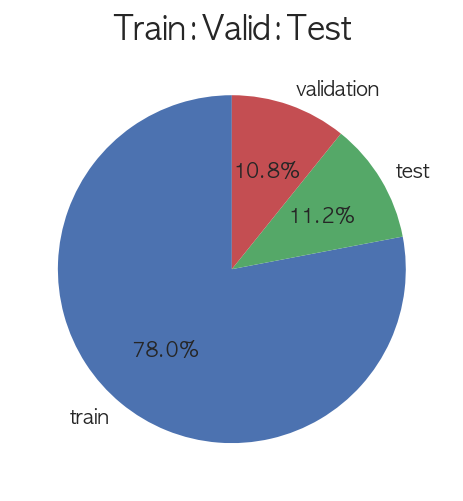

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from utils.fontlib import set_font_family
set_font_family()

fig = plt.figure(facecolor=(1,1,1), figsize=(4,4))
split_size = info_df.split.value_counts()
plt.pie(split_size, labels=split_size.index, startangle=90, autopct='%.1f%%')
plt.title("Train:Valid:Test", fontsize=16)
plt.show()

8:1:1 비율로 train/valid/test 데이터가 분리된 것을 확인할 수 있습니다.

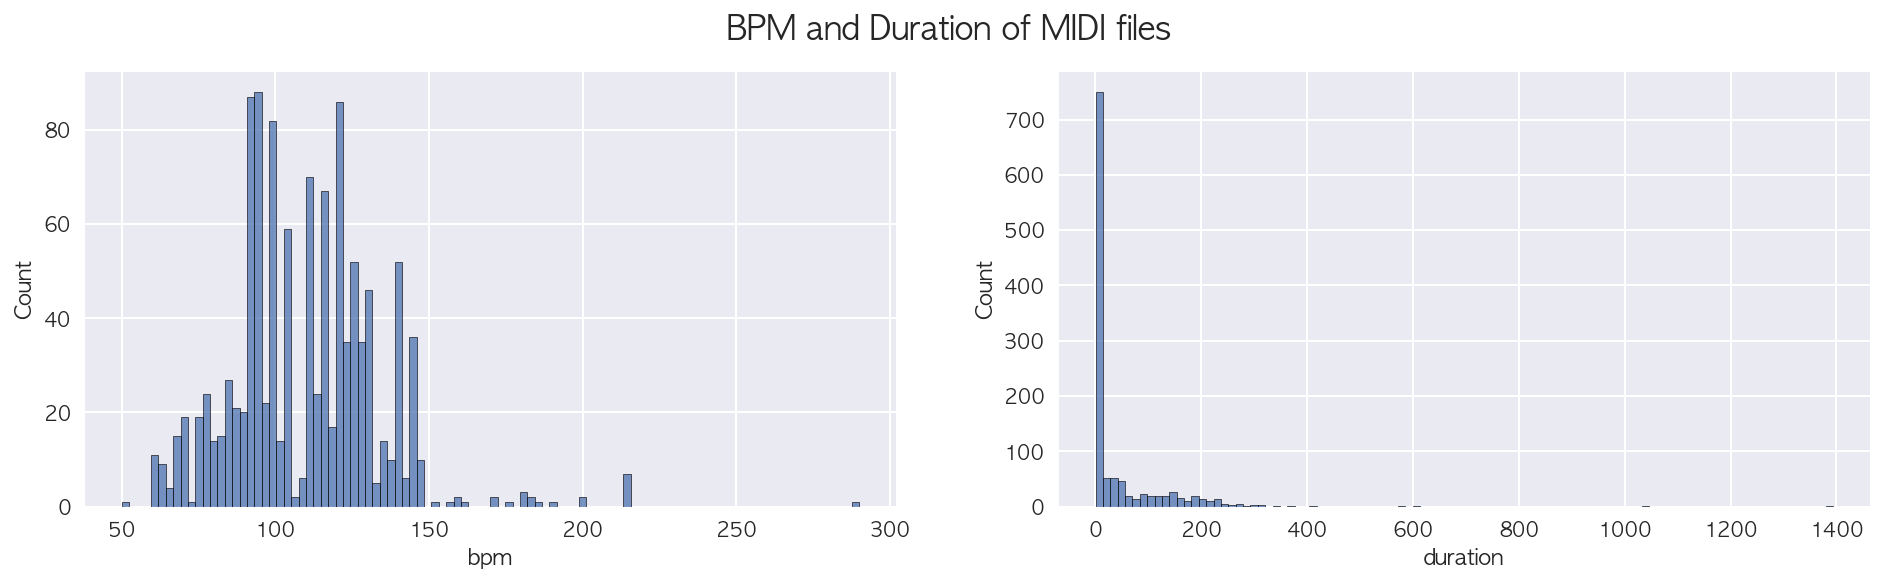

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))
sns.histplot(ax=ax[0], data=info_df, x='bpm', bins=100)
sns.histplot(ax=ax[1], data=info_df, x='duration', bins=100)
plt.suptitle("BPM and Duration of MIDI files", fontsize=16)
plt.show()

bpm과 duration에 대한 분포를 시각화했습니다.   
대부분이 짧은 곡이지만 유난히 길이가 긴 곡이 일부 포함되어 있는 것을 알 수 있습니다.

추가적으로 MIDI 파일에 어떤 소리가 기록되어 있는지 확인하기 위해 Logic으로 재생한 내역을 녹화하였고,   
해당 [영상 다운로드](https://github.com/minyeamer/groove_midi/blob/main/.media/midi.mov?raw=true)를 통해 확인할 수 있습니다.

<hr>

## Implementation
- MIDI 파일을 TFRecord 파일로 변환합니다.
- Custom CONFIG_MAP을 생성합니다.
- [Magenta 사용법](https://github.com/magenta/magenta/tree/main/magenta/models/music_vae#how-to-use)을 참고하여 `music_vae_train.py` 스크립트를 수행해 학습합니다.
- [Magenta 사용법](https://github.com/magenta/magenta/tree/main/magenta/models/music_vae#how-to-use)을 참고하여 `music_vae_generate.py` 스크립트를 수행해 학습합니다.
- 개별적으로 알아보고 싶은 함수들을 실행하여 반환값을 확인합니다.
- (08-20 17:00-22:00, 5 hours)

<hr style="border-style:dotted">

### TFRecord 변환
- `convert_directory()` 함수를 사용해 MIDI 파일을 포함하는 전체 디렉토리를 TFRecord 파일로 변환합니다.
- Path 객체를 그대로 집어넣으면 내부에서 인식하지 못하므로 str 타입으로 변환해 전달합니다.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from magenta.scripts.convert_dir_to_note_sequences import convert_directory

tfrec_file = data_path/'midi.tfrecord'
convert_directory(midi_path.__str__(), tfrec_file.__str__(), recursive=True)
clear_output()

<hr style="border-style:dotted">

### Custom CONFIG_MAP 생성
- `music_vae_train.py`는 무조건 `config_map`에 대한 키값으로 설정 정보를 불러오기 때문에,   
  `configs.py` 내에 직접 custom config를 주입하여 해당하는 키값으로 접근할 수 있도록 합니다.
- custom config의 경우 앞서 살펴보았던 `cat-mel_2bar_small`과 `hierdec-trio_16bar`를 적절히 조합해 작성합니다.
- colab에서 설치된 패키지를 직접 수정하는 방법을 찾지 못하여 로컬에서 파일을 수정하고 재설치를 통해 변경사항을 업데이트하도록 했습니다.

In [ ]:
!git clone https://github.com/magenta/magenta

In [ ]:
custom_config = f"""
CONFIG_MAP['hierdec-drums_4bar_small'] = Config(
    model=MusicVAE(
        lstm_models.BidirectionalLstmEncoder(),
        lstm_models.HierarchicalLstmDecoder(
            lstm_models.CategoricalLstmDecoder(),
            level_lengths=[16, 4],
            disable_autoregression=True)),
    hparams=merge_hparams(
        lstm_models.get_default_hparams(),
        HParams(
            batch_size=512,
            max_seq_len=64,  # 4 bars w/ 16 steps per bar
            z_size=256,
            enc_rnn_size=[512, 512],
            dec_rnn_size=[256, 256],
            free_bits=48,
            max_beta=0.2,
            sampling_schedule='inverse_sigmoid',
            sampling_rate=1000,
        )),
    note_sequence_augmenter=None,
    data_converter=data.DrumsConverter(
        max_bars=100,  # Truncate long drum sequences before slicing.
        slice_bars=4,
        steps_per_quarter=4,
        roll_input=True),
    train_examples_path='{tfrec_file.__str__()}',
)"""

In [ ]:
config_file = root_path/"magenta/magenta/models/music_vae/configs.py"

with open(config_file, 'a') as file:
    file.write(custom_config)

In [ ]:
!pip install -e magenta
clear_output()

<hr style="border-style:dotted">

### Train
- `config`, `run_dir`, `num_steps`, `mode`를 지정하여 `music_vae_train.py` 스크립트를 실행합니다.

In [ ]:
!python3 magenta/magenta/models/music_vae/music_vae_train.py \
  --config=hierdec-drums_4bar_small \
  --run_dir=saved/checkpoints/drums_4bar \
  --num_steps=10 \
  --mode=train

<hr style="border-style:dotted">

### Generate
- `config`, `checkpoint_file`, `mode`, `num_outputs`, `output_dir`을 지정하여 `music_vae_generate.py` 스크립트를 실행합니다.
- 실행 결과 4마디로 구성된 MIDI 파일 5개가 생성됩니다.

In [ ]:
!python3 magenta/magenta/models/music_vae/music_vae_generate.py \
  --config=hierdec-drums_4bar_small \
  --checkpoint_file=saved/checkpoints/groove_4bar \
  --mode=sample \
  --num_outputs=5 \
  --output_dir=saved/generated

<hr style="border-style:dotted">

### Debug
- MusicVAE의 입력값으로 사용되는, `_get_input_tensors()` 함수의 출력 결과를 확인합니다.
- 위 입력값에 대한 인코딩을 통해 얻을 수 있는 $\mu, \sigma$ 값을 확인합니다.
- `TrainedModel` 객체를 생성하고 출력 시퀀스에 대한 그래프를 확인합니다.

In [ ]:
import collections
from magenta.common import merge_hparams
from magenta.contrib import training as contrib_training
from magenta.models.music_vae import configs
from magenta.models.music_vae import data
from magenta.models.music_vae import lstm_models
from magenta.models.music_vae import music_vae_train
from magenta.models.music_vae.base_model import MusicVAE
from magenta.models.music_vae.trained_model import TrainedModel
import tensorflow.compat.v1 as tf
import note_seq

In [ ]:
HParams = contrib_training.HParams

class Config(collections.namedtuple(
    'Config',
    ['model', 'hparams', 'note_sequence_augmenter', 'data_converter',
     'train_examples_path', 'eval_examples_path', 'tfds_name'])):

  def values(self):
    return self._asdict()

Config.__new__.__defaults__ = (None,) * len(Config._fields)

CONFIG_MAP = configs.CONFIG_MAP

CONFIG_MAP['hierdec-drums_4bar_small'] = Config(
    model=MusicVAE(
        lstm_models.BidirectionalLstmEncoder(),
        lstm_models.HierarchicalLstmDecoder(
            lstm_models.CategoricalLstmDecoder(),
            level_lengths=[16, 4],
            disable_autoregression=True)),
    hparams=merge_hparams(
        lstm_models.get_default_hparams(),
        HParams(
            batch_size=512,
            max_seq_len=64,  # 4 bars w/ 16 steps per bar
            z_size=256,
            enc_rnn_size=[512, 512],
            dec_rnn_size=[256, 256],
            free_bits=48,
            max_beta=0.2,
            sampling_schedule='inverse_sigmoid',
            sampling_rate=1000,
        )),
    note_sequence_augmenter=None,
    data_converter=data.DrumsConverter(
        max_bars=100,  # Truncate long drum sequences before slicing.
        slice_bars=4,
        steps_per_quarter=4,
        roll_input=True),
    train_examples_path=tfrec_file.__str__(),
)

#### Print Input Tensors

In [ ]:
tf_file_reader = tf.data.TFRecordDataset
config = CONFIG_MAP['hierdec-drums_4bar_small']

def dataset_fn():
    return data.get_dataset(
        config,
        tf_file_reader=tf_file_reader,
        is_training=True)

input_tensors = music_vae_train._get_input_tensors(dataset_fn(), config)

In [ ]:
input_tensors.keys()

dict_keys(['input_sequence', 'output_sequence', 'control_sequence', 'sequence_length'])

In [ ]:
print(input_tensors['input_sequence'].shape)
print(input_tensors['input_sequence'][0])

(512, 64, 10)
tf.Tensor(
[[ True False  True False False False False False False False]
 [False False False False False False False False False  True]
 [False False  True False False False False False False False]
 [False False False False False False False False False  True]
 [ True  True False False False False False False False False]
 [False False  True False False False False False False False]
 [False False  True False False False False False False False]
 [False False False False False False False False False  True]
 [ True False False False False False False False False False]
 [False False  True False False False False False False False]
 [False  True False False False False False False False False]
 [False False False False False False False False False  True]
 [ True False False  True False False False False False False]
 [False  True False False False False False False False False]
 [False  True False False False False False False False False]
 [False False False False Fals

In [ ]:
print(input_tensors['output_sequence'].shape)
print(input_tensors['output_sequence'][0][0])

(512, 64, 512)
tf.Tensor(
[False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False 

In [ ]:
print(input_tensors['control_sequence'])

None


In [ ]:
print(input_tensors['sequence_length'])

tf.Tensor(
[64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 

#### Print Encoder Output

In [ ]:
model = config.model
model.build(config.hparams,
            config.data_converter.output_depth,
            is_training=True)
print(model._encoder)
print(model._decoder)

In [ ]:
def encode(sequence, sequence_length, control_sequence=None):

    hparams = config.hparams
    z_size = hparams.z_size

    sequence = tf.to_float(sequence)
    if control_sequence is not None:
        control_sequence = tf.to_float(control_sequence)
        sequence = tf.concat([sequence, control_sequence], axis=-1)
    encoder_output = model.encoder.encode(sequence, sequence_length)

    mu = tf.layers.dense(
        encoder_output,
        z_size,
        name='encoder/mu',
        kernel_initializer=tf.random_normal_initializer(stddev=0.001))
    sigma = tf.layers.dense(
        encoder_output,
        z_size,
        activation=tf.nn.softplus,
        name='encoder/sigma',
        kernel_initializer=tf.random_normal_initializer(stddev=0.001))

    return mu, sigma

In [ ]:
input_sequence = input_tensors['input_sequence']
sequence_length = input_tensors['sequence_length']
mu, sigma = encode(input_sequence, sequence_length)

In [ ]:
mu

<tf.Tensor: shape=(512, 256), dtype=float32, numpy=
array([[ 3.5985588e-04,  3.8989724e-04, -1.6418722e-05, ...,
        -6.8864450e-05,  1.0071536e-04,  4.9026031e-04],
       [ 8.6927379e-04,  5.5203756e-04, -2.2198050e-04, ...,
         1.7228586e-04, -5.6761462e-04, -5.9401459e-04],
       [ 3.4629149e-04,  2.4729094e-04,  6.9202331e-05, ...,
         1.9021984e-04,  4.2038097e-05,  3.0057502e-04],
       ...,
       [ 6.5475103e-04,  4.4984886e-04, -2.8081797e-04, ...,
        -3.6981446e-04, -2.6055065e-04,  5.4954039e-04],
       [ 5.8174646e-04,  4.9551873e-04,  5.5557757e-07, ...,
         6.3289778e-04, -7.1067177e-04, -1.1163799e-03],
       [ 2.0881589e-04,  3.7205539e-04, -1.8555974e-04, ...,
        -7.9960830e-04, -8.8741077e-04,  1.4579445e-03]], dtype=float32)>

In [ ]:
sigma

<tf.Tensor: shape=(512, 256), dtype=float32, numpy=
array([[0.6930088 , 0.69302344, 0.69288254, ..., 0.6932787 , 0.6929438 ,
        0.69354165],
       [0.692941  , 0.6932618 , 0.6928269 , ..., 0.69337744, 0.6930389 ,
        0.6931819 ],
       [0.69289094, 0.69286317, 0.69311476, ..., 0.6930538 , 0.69307935,
        0.69363165],
       ...,
       [0.6929597 , 0.69288903, 0.6928437 , ..., 0.69341576, 0.69294107,
        0.6936339 ],
       [0.6930789 , 0.693032  , 0.69323415, ..., 0.6928626 , 0.6933422 ,
        0.69322896],
       [0.69316   , 0.692927  , 0.69258964, ..., 0.693778  , 0.6930011 ,
        0.69339   ]], dtype=float32)>

#### Plot MusicVAE Output

In [ ]:
checkpoint_file = root_path/"saved/checkpoints/drums_4bar/train/model.ckpt-10"
num_outputs = 5

config.data_converter.max_tensors_per_item = None
checkpoint_dir_or_path = os.path.expanduser(checkpoint_file)

model = TrainedModel(
    config, batch_size=num_outputs,
    checkpoint_dir_or_path=checkpoint_dir_or_path)

In [ ]:
temperature = 0.5
samples = model.sample(n=5, length=64, temperature=temperature)

for sequence in samples:
    note_seq.plot_sequence(sequence)

마찬가지로 생성된 MIDI 파일에 어떤 소리가 기록되어 있는지 확인하기 위해 Logic으로 재생한 내역을 녹화하였고,   
해당 [영상 다운로드](https://github.com/minyeamer/groove_midi/blob/main/.media/output.mov?raw=true)를 통해 확인할 수 있습니다.

<hr>

## Appendix
- `configs.py` 파일을 직접 수정해야 하는 기존의 불편함을 개선하면서 더욱 직관적인 방식으로 config 파일을 사용하기 위해,   
  Magenta 소스코드를 가져와 별도의 실행 파일 `run.py`를 만들었습니다. (08-21 10:00-14:00, 4 hours)

In [ ]:
# Train

!python3 run.py \
  --config=hierdec-drums_4bar_small \
  --config_file=data/config.json \
  --run_dir=saved/checkpoints/drums_4bar \
  --num_steps=10 \
  --mode=train

In [ ]:
# Generate

!python3 run.py \
  --config=hierdec-drums_4bar_small \
  --config_file=data/config.json \
  --checkpoint_file=checkpoints/drums_4bar/train/model.ckpt-10 \
  --output_dir=generated/test \
  --num_outputs=5 \
  --mode=sample